# Autoregressive Tree HMM Demo

## Setup

In [1]:
import sys
import os

# sys.path.insert(0, os.path.expanduser('~/Documents/dynamax'))


In [2]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import seaborn as sns

from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from models.tarhmm import tARHMM
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation
from dynamax.hidden_markov_model.models.tarhmm import tree_hmm_backward_filter
from typing import Callable, Optional
from dynamax.types import IntScalar, Float, Array


### Helper functions for plotting

In [3]:
sns.set_style("white")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink"
]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

## Sample from tree ARHMM
GPT-written function to sample from this model. To be replaced by better sampler later.

In [4]:
import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np
from jax.scipy.stats import multivariate_normal

def generate_tree_hmm_data(
    key,
    num_timesteps=100,
    max_cells=256,
    num_states=3,
    emission_dim=2,
    division_prob=0.1,
    death_prob=0.05,
    new_root_prob=0.8
):
    """
    Generates dummy data for a Tree HMM with AR Gaussian emissions.
    Uses STRICT UNIQUE IDS: Every biological cell gets a unique column index.
    - If a cell dies, its column is never reused.
    - If a cell divides, the parent column ends, and 2 NEW columns are assigned to children.
    - This makes the arrays sparse but guarantees Column K = Cell ID K.
    """
    k1, k2, k3, k4 = jr.split(key, 4)

    # --- 1. Define Model Parameters ---
    P_std = jnp.array([[0.8, 0.1, 0.1], [0.1, 0.8, 0.1], [0.1, 0.1, 0.8]])
    P_div = jnp.array([[0.9, 0.05, 0.05], [0.9, 0.05, 0.05], [0.9, 0.05, 0.05]])

    AR_weights = jr.normal(k1, (num_states, emission_dim, emission_dim)) * 0.5
    AR_biases = jr.normal(k2, (num_states, emission_dim))
    Emission_cov = jnp.eye(emission_dim) * 0.1

    # Initial distribution (used for roots, including spontaneous new roots)
    initial_distribution = jnp.array([1.0, 0.0, 0.0])

    # --- 2. Initialize Arrays ---
    parent_indices = np.zeros((num_timesteps, max_cells), dtype=np.int32)
    is_division_mask = np.zeros((num_timesteps, max_cells), dtype=bool)
    is_new_root_mask = np.zeros((num_timesteps, max_cells), dtype=bool)
    active_mask = np.zeros((num_timesteps, max_cells), dtype=bool)
    true_states = np.zeros((num_timesteps, max_cells), dtype=np.int32)
    observations = np.zeros((num_timesteps, max_cells, emission_dim))
    parent_observations = np.zeros((num_timesteps, max_cells, emission_dim))

    # --- 3. Simulation Loop ---
    
    # Global counter for Unique Cell IDs (mapped to column indices)
    # Start with 1 because 0 is taken by the initial root
    next_unique_id = 1 
    
    # State tracking: mapping column_idx -> {'state': int, 'obs': array}
    # Only currently active cells are in this map
    current_active_cells = {}

    # Initialize Root at t=0 in Column 0
    current_active_cells[0] = {
        'state': 0,
        'obs': np.zeros(emission_dim)
    }
    
    # Set t=0 arrays for Root
    active_mask[0, 0] = True
    is_new_root_mask[0, 0] = True
    true_states[0, 0] = 0
    observations[0, 0] = np.zeros(emission_dim)
    # parent_indices[0, 0] is 0
    # parent_observations[0, 0] is 0

    sim_keys = jr.split(k3, num_timesteps)
    new_root_keys = jr.split(k4, num_timesteps)

    for t in range(num_timesteps - 1):
        key_t = sim_keys[t]
        key_root_t = new_root_keys[t]
        
        next_active_cells = {}
        
        # A. Process Currently Active Cells
        sorted_ids = sorted(current_active_cells.keys())
        
        for pid in sorted_ids: # pid = Parent Column ID
            cell = current_active_cells[pid]
            
            fate_key, trans_key, obs_key = jr.split(jr.fold_in(key_t, pid), 3)
            fate_roll = float(jr.uniform(fate_key))
            
            fate = "continue"
            if fate_roll < death_prob:
                fate = "die"
            elif fate_roll < death_prob + division_prob:
                fate = "divide"
            
            # Check capacity before branching
            # If we need 2 new IDs but only have 1 slot left, force death or continue
            if fate == "divide" and next_unique_id + 2 > max_cells:
                fate = "die" # Out of unique IDs
            
            # --- Execute Fate ---
            
            if fate == "die":
                pass # Parent pid is not added to next_active_cells. It ends here.
                
            elif fate == "continue":
                # Cell persists in the SAME column (pid)
                target_id = pid
                
                # Transition
                state_probs = P_std[cell['state']]
                next_state = int(jr.choice(trans_key, np.arange(num_states), p=state_probs))
                
                # AR Obs (Input is Self)
                ar_input = cell['obs']
                mean = AR_weights[next_state] @ ar_input + AR_biases[next_state]
                next_obs = mean + np.array(jr.multivariate_normal(obs_key, np.zeros(emission_dim), Emission_cov))
                
                next_active_cells[target_id] = {'state': next_state, 'obs': next_obs}
                
                # Record in Arrays (t+1)
                active_mask[t+1, target_id] = True
                parent_indices[t+1, target_id] = pid # Parent is Self
                true_states[t+1, target_id] = next_state
                observations[t+1, target_id] = next_obs
                parent_observations[t+1, target_id] = ar_input
            
            elif fate == "divide":
                # Parent pid ends. Two NEW unique IDs are born.
                child_id_1 = next_unique_id
                child_id_2 = next_unique_id + 1
                next_unique_id += 2
                
                # Transition (Both children use Division matrix)
                state_probs = P_div[cell['state']]
                
                # Create Children
                # Note: We share the division transition logic for both but sample independently
                sub_keys = jr.split(trans_key, 2)
                obs_keys = jr.split(obs_key, 2)
                
                for i, cid in enumerate([child_id_1, child_id_2]):
                    # Sample State
                    next_state = int(jr.choice(sub_keys[i], np.arange(num_states), p=state_probs))
                    
                    # AR Obs (Input is 0.0 for division)
                    ar_input = np.zeros(emission_dim)
                    mean = AR_weights[next_state] @ ar_input + AR_biases[next_state]
                    next_obs = mean + np.array(jr.multivariate_normal(obs_keys[i], np.zeros(emission_dim), Emission_cov))
                    
                    next_active_cells[cid] = {'state': next_state, 'obs': next_obs}
                    
                    # Record
                    active_mask[t+1, cid] = True
                    parent_indices[t+1, cid] = pid # Parent is 'pid'
                    is_division_mask[t+1, cid] = True
                    true_states[t+1, cid] = next_state
                    observations[t+1, cid] = next_obs
                    parent_observations[t+1, cid] = ar_input # 0.0

        # B. Spontaneous New Roots
        if next_unique_id < max_cells:
            if float(jr.uniform(key_root_t)) < new_root_prob:
                new_root_id = next_unique_id
                next_unique_id += 1
                
                k_s, k_o = jr.split(key_root_t)
                next_state = int(jr.choice(k_s, jnp.arange(num_states), p=initial_distribution))
                
                # Input 0.0
                ar_input = np.zeros(emission_dim)
                mean = AR_biases[next_state]
                next_obs = mean + np.array(jr.multivariate_normal(k_o, np.zeros(emission_dim), Emission_cov))
                
                next_active_cells[new_root_id] = {'state': next_state, 'obs': next_obs}
                
                active_mask[t+1, new_root_id] = True
                is_new_root_mask[t+1, new_root_id] = True
                true_states[t+1, new_root_id] = next_state
                observations[t+1, new_root_id] = next_obs
                parent_observations[t+1, new_root_id] = ar_input
                parent_indices[t+1, new_root_id] = 0 # Dummy

        # Advance
        current_active_cells = next_active_cells

    # --- 4. Finalize ---
    observations_jax = jnp.array(observations)
    parent_obs_jax = jnp.array(parent_observations)
    active_mask_jax = jnp.array(active_mask)

    def compute_ar_log_prob(obs_t, obs_tm1, weights, biases, cov):
        means = jnp.einsum('kij,j->ki', weights, obs_tm1) + biases
        log_probs = jax.vmap(
            lambda m: multivariate_normal.logpdf(obs_t, m, cov)
        )(means)
        return log_probs

    log_likelihoods = jax.vmap(jax.vmap(
        lambda y, y_prev: compute_ar_log_prob(y, y_prev, AR_weights, AR_biases, Emission_cov)
    ))(observations_jax, parent_obs_jax)

    log_likelihoods = log_likelihoods * active_mask_jax[:, :, None]

    print(f"Generated sparse data for {num_timesteps} steps.")
    print(f"Total Unique Cells Created: {next_unique_id}")
    
    return {
        "initial_distribution": initial_distribution,
        "transition_matrices": (P_std, P_div),
        "log_likelihoods": log_likelihoods,
        "parent_indices": jnp.array(parent_indices),
        "is_division_mask": jnp.array(is_division_mask),
        "is_new_root_mask": jnp.array(is_new_root_mask),
        "active_mask": active_mask_jax,
        "observations": observations_jax,
        "parent_observations": parent_obs_jax,
        "params": {"AR_weights": AR_weights, "AR_biases": AR_biases, "cov": Emission_cov}
    }


key = jr.PRNGKey(1)
data = generate_tree_hmm_data(key, new_root_prob=0.7)

# Check Division Input
t = 5
print(f"\nTime {t} Snapshot:")
div_indices = jnp.where(data['is_division_mask'][t] & data['active_mask'][t])[0]
if len(div_indices) > 0:
    idx = div_indices[0]
    print(f"Dividing Cell Index: {idx}")
    print(f"Parent Observation (Should be 0.0): {data['parent_observations'][t][idx]}")
    print(f"Did it divide?: {data['is_division_mask'][t][idx]}")

Generated sparse data for 100 steps.
Total Unique Cells Created: 256

Time 5 Snapshot:
Dividing Cell Index: 8
Parent Observation (Should be 0.0): [0. 0.]
Did it divide?: True


In [5]:
emissions = data['observations']
num_states = 3
emission_dim = 2
num_lags = 1

In [6]:
arhmm = tARHMM(num_states, emission_dim, num_lags=num_lags)
params, props = arhmm.initialize(key=jr.PRNGKey(1), method="kmeans", emissions=emissions)
inputs = arhmm.compute_inputs(emissions,                        
    data['parent_indices'],
    data['is_division_mask'],
    data['is_new_root_mask'],
    data['active_mask'])
# arhmm.e_step(params, emissions,inputs=inputs)


In [7]:
from dynamax.hidden_markov_model.models.tarhmm import tree_hmm_filter, tree_hmm_two_filter_smoother
# post = tree_hmm_filter(*arhmm._inference_args(params, emissions, inputs, data['parent_indices'], data['is_division_mask'], data['active_mask'],data['is_new_root_mask']))
# input_fwd = arhmm._inference_args(params, emissions, inputs, data['parent_indices'], data['is_division_mask'], data['active_mask'],data['is_new_root_mask'])
def inputs_for_backward_filter(
    initial_distribution,   # (num_states,)
    transition_matrices,    # tuple of (P_std, P_div) each (num_states, num_states)
    log_likelihoods,        # (T, MAX_CELLS, K)
    parent_indices,         # (T, MAX_CELLS)
    is_division_mask,       # (T, MAX_CELLS)
    active_mask,            # (T, MAX_CELLS)
    is_new_root_mask,       # (T, MAX_CELLS)
    transition_fn: Optional[Callable[[IntScalar], Float[Array, "num_states num_states"]]] = None,
    division_transition_fn: Optional[Callable[[IntScalar], Float[Array, "num_states num_states"]]] = None
):
    return transition_matrices, log_likelihoods, parent_indices, is_division_mask, active_mask, is_new_root_mask
# transition_matrices, log_likelihoods, parent_indices, is_division_mask, active_mask, is_new_root_mask = inputs_for_backward_filter(*input_fwd)
# log_normalizer, backward_pred_probs = tree_hmm_backward_filter(*inputs_for_backward_filter(*input_fwd))
# post = tree_hmm_two_filter_smoother(*input_fwd)

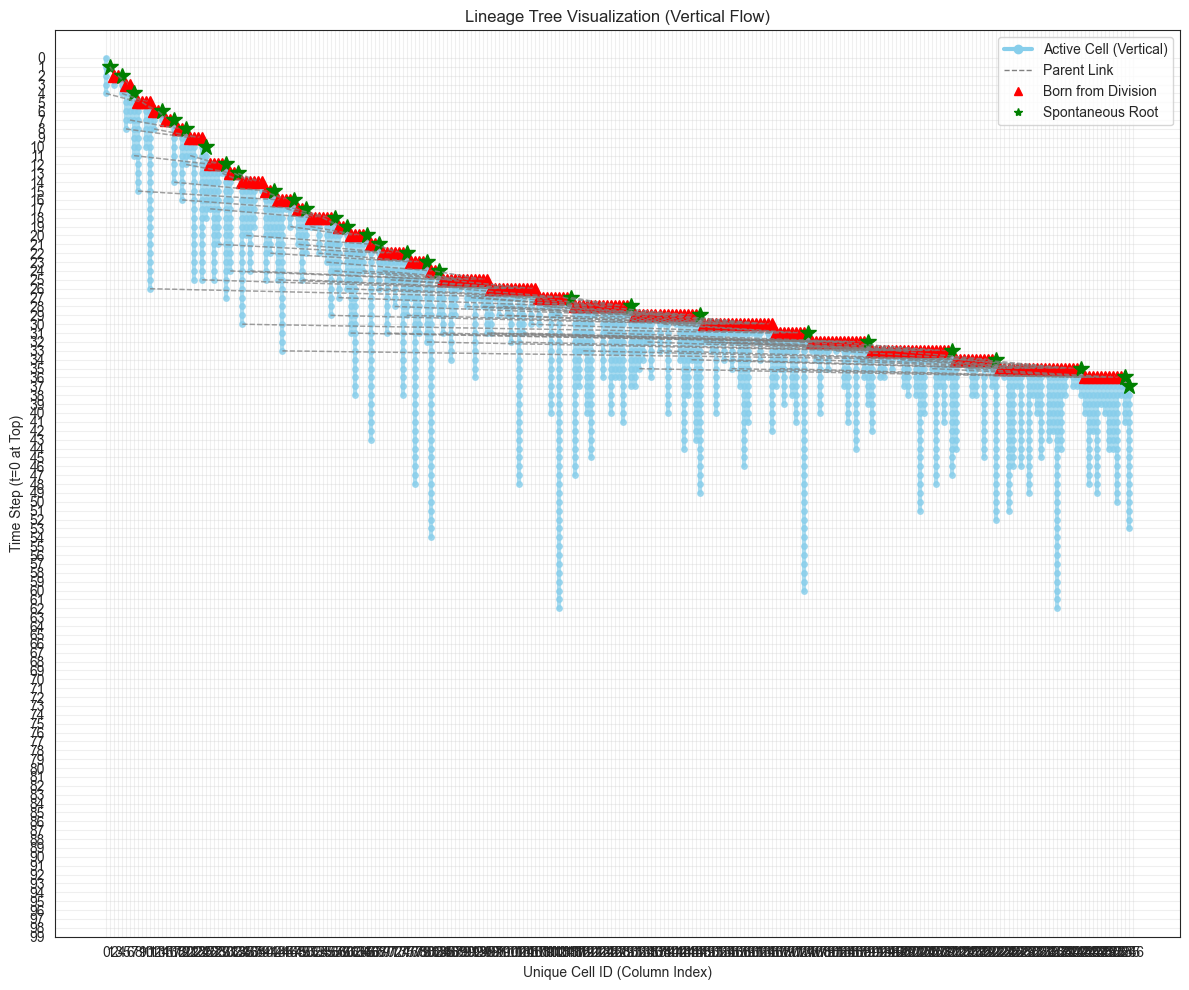

In [8]:
import matplotlib.pyplot as plt
import jax.random as jr
import jax.numpy as jnp
import numpy as np

# Import your generator
def visualize_lineage(data):
    """
    Visualizes the tree lineage vertically.
    Y-axis: Time (starts at 0 at the top, goes down).
    X-axis: Unique Cell ID.
    """
    parent_indices = np.array(data['parent_indices'])
    active_mask = np.array(data['active_mask'])
    is_new_root = np.array(data['is_new_root_mask'])
    is_division = np.array(data['is_division_mask'])
    
    T, MaxCells = active_mask.shape
    
    plt.figure(figsize=(12, 10))
    
    # 1. Draw Cell Tracks (Vertical Lines)
    # We iterate by ID to draw contiguous vertical lines for each unique cell
    
    for cell_id in range(MaxCells):
        # Find time points where this cell is active
        active_times = np.where(active_mask[:, cell_id])[0]
        
        if len(active_times) > 0:
            # Draw the life of the cell vertically
            # X = Cell ID (Constant), Y = Time (Variable)
            plt.plot([cell_id] * len(active_times), active_times, 
                     marker='o', markersize=4, linewidth=3, alpha=0.7, 
                     color='skyblue', label='Cell Life' if cell_id == 0 else "")
            
            # Label the start of the track
            t_start = active_times[0]
            
            # 2. Draw Connections to Parents (Upwards)
            if t_start > 0:
                parent_id = parent_indices[t_start, cell_id]
                
                # Check if this is a "New Root" (Spontaneous) or a Child
                if is_new_root[t_start, cell_id]:
                    # Star marker for spontaneous appearance
                    plt.plot(cell_id, t_start, marker='*', color='green', markersize=12, label='New Root' if cell_id==0 else "")
                else:
                    # Draw connection line from Parent(t-1) to Child(t)
                    # Parent is at (parent_id, t_start - 1)
                    # Child is at (cell_id, t_start)
                    plt.plot([parent_id, cell_id], [t_start - 1, t_start], 
                             color='gray', linestyle='--', linewidth=1, alpha=0.5)
                    
                    # If this was a division, mark the birth point
                    if is_division[t_start, cell_id]:
                         plt.plot(cell_id, t_start, marker='^', color='red', markersize=8, label='Division Child' if cell_id==0 else "")

    plt.ylabel("Time Step (t=0 at Top)")
    plt.xlabel("Unique Cell ID (Column Index)")
    plt.title("Lineage Tree Visualization (Vertical Flow)")
    
    # Invert Y axis so time goes down
    plt.gca().invert_yaxis()
    
    # Grid and Ticks
    plt.grid(True, alpha=0.3)
    # Set X ticks to integers for IDs, limiting to max active ID
    max_used_id = np.max(np.where(active_mask)[1])
    plt.xticks(np.arange(0, max_used_id + 2, 1))
    plt.yticks(np.arange(0, T, 1))
    
    # Create a custom legend manually to avoid duplicate labels
    from matplotlib.lines import Line2D
    custom_lines = [
        Line2D([0], [0], color='skyblue', lw=3, marker='o', label='Active Cell (Vertical)'),
        Line2D([0], [0], color='gray', lw=1, linestyle='--', label='Parent Link'),
        Line2D([0], [0], color='red', lw=0, marker='^', label='Born from Division'),
        Line2D([0], [0], color='green', lw=0, marker='*', label='Spontaneous Root')
    ]
    plt.legend(handles=custom_lines, loc='upper right')
    
    plt.tight_layout()
    plt.show()


    

visualize_lineage(data)

In [9]:
# cell_id = 3
# pd.DataFrame({'active':data['active_mask'][:,cell_id],'is_division':data['is_division_mask'][:,cell_id],'is_new_root':data['is_new_root_mask'][:,cell_id],'parent_id':data['parent_indices'][:,cell_id]})

In [10]:
import importlib

In [11]:
arhmm = tARHMM(num_states, emission_dim, num_lags=num_lags)
params, props = arhmm.initialize(key=jr.PRNGKey(1), method="kmeans", emissions=emissions)
inputs = arhmm.compute_inputs(emissions,                        
    data['parent_indices'],
    data['is_division_mask'],
    data['is_new_root_mask'],
    data['active_mask'])
# arhmm.e_step(params, emissions,inputs=inputs)

# e_step = arhmm.e_step(params,emissions,inputs,data['parent_indices'],data['is_division_mask'],data['active_mask'],data['is_new_root_mask'])

In [12]:
fitted_params, lps = arhmm.fit_em(params, props, emissions, inputs=inputs,
    parent_indices=data['parent_indices'],
    is_division_mask=data['is_division_mask'],
    active_mask=data['active_mask'],
    is_new_root_mask=data['is_new_root_mask'])

In [13]:
fitted_params.transitions

ParamsStandardHMMTransitions(transition_matrix=Array([[0.82330316, 0.0958568 , 0.08084002],
       [0.10073172, 0.8041066 , 0.09516165],
       [0.10400401, 0.11951122, 0.7764848 ]], dtype=float32))

In [14]:
fitted_params.division_transitions

ParamsStandardHMMTransitions(transition_matrix=Array([[0.21395555, 0.68641603, 0.0996284 ],
       [0.13385051, 0.82557505, 0.04057442],
       [0.01569286, 0.92397237, 0.06033476]], dtype=float32))

In [15]:
data['initial_distribution']

Array([1., 0., 0.], dtype=float32)

In [16]:
fitted_params.emissions.weights

Array([[[ 0.25014377,  0.74061203],
        [-0.5652171 ,  0.04634779]],

       [[-0.09498972, -0.99066544],
        [ 0.30340144,  0.8060814 ]],

       [[ 0.3440651 ,  0.17838895],
        [-0.06939653,  0.91992664]]], dtype=float32)

In [17]:
data['params']['AR_weights']

Array([[[-0.0841407 , -0.98816055],
        [ 0.28739882,  0.79270744]],

       [[ 0.31808856,  0.16670457],
        [-0.08117945,  0.9363434 ]],

       [[ 0.22002456,  0.775385  ],
        [-0.54534525,  0.08319184]]], dtype=float32)

In [18]:
fitted_params.initial

ParamsStandardHMMInitialState(probs=Array([0.01768943, 0.978189  , 0.0041215 ], dtype=float32))

In [19]:
# Compare these two:
print("True Biases (Sorted):\n", jnp.sort(data['params']['AR_biases'][:, 0]))
print("Fitted Biases (Sorted):\n", jnp.sort(fitted_params.emissions.biases[:, 0]))

True Biases (Sorted):
 [-1.9466462 -1.4583627 -1.2851919]
Fitted Biases (Sorted):
 [-1.923408  -1.3793751 -1.2869064]


## Parameter Comparison: True vs Fitted


STATE ALIGNMENT (using AR biases)
Cost matrix (Euclidean distance on biases):
[[0.16443056 0.0073816  0.98818296]
 [1.07744277 1.02803183 0.03546271]
 [0.09058197 0.1906051  0.96441889]]

Optimal assignment: True state i -> Fitted state perm[i]
Permutation: [1 2 0]
Total alignment cost: 0.1334


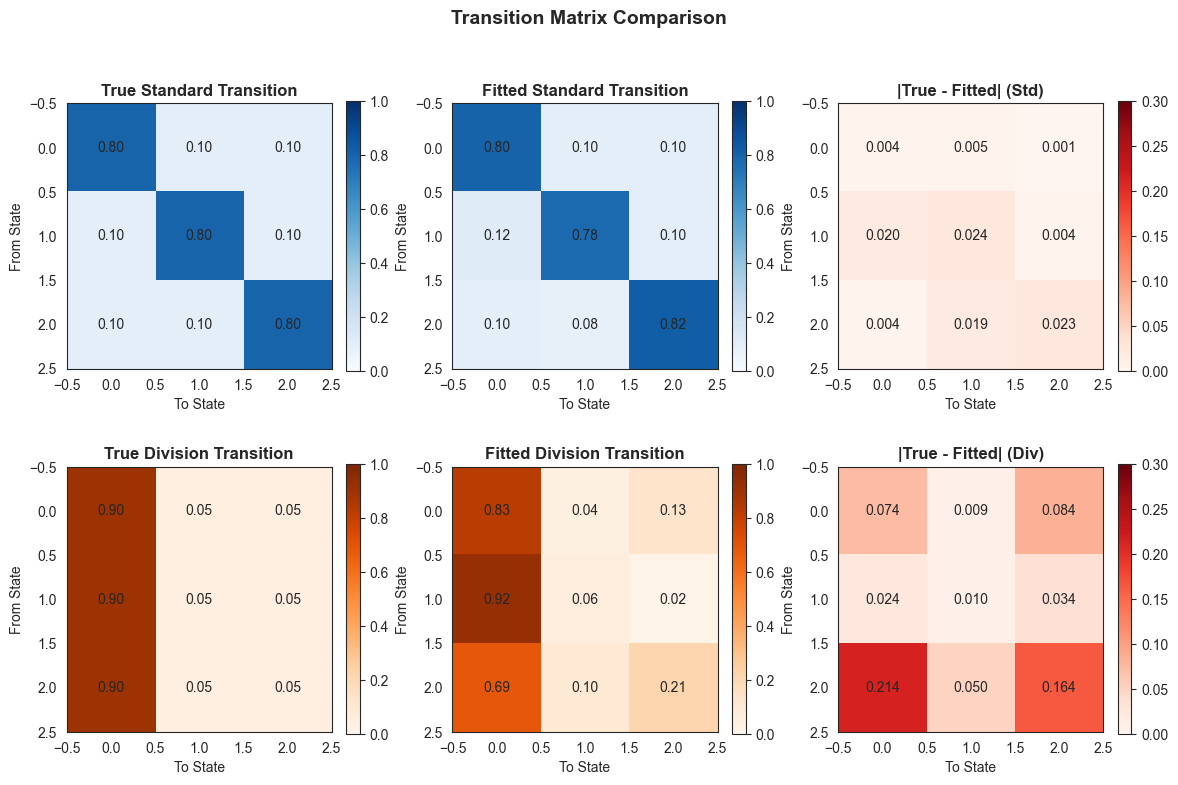

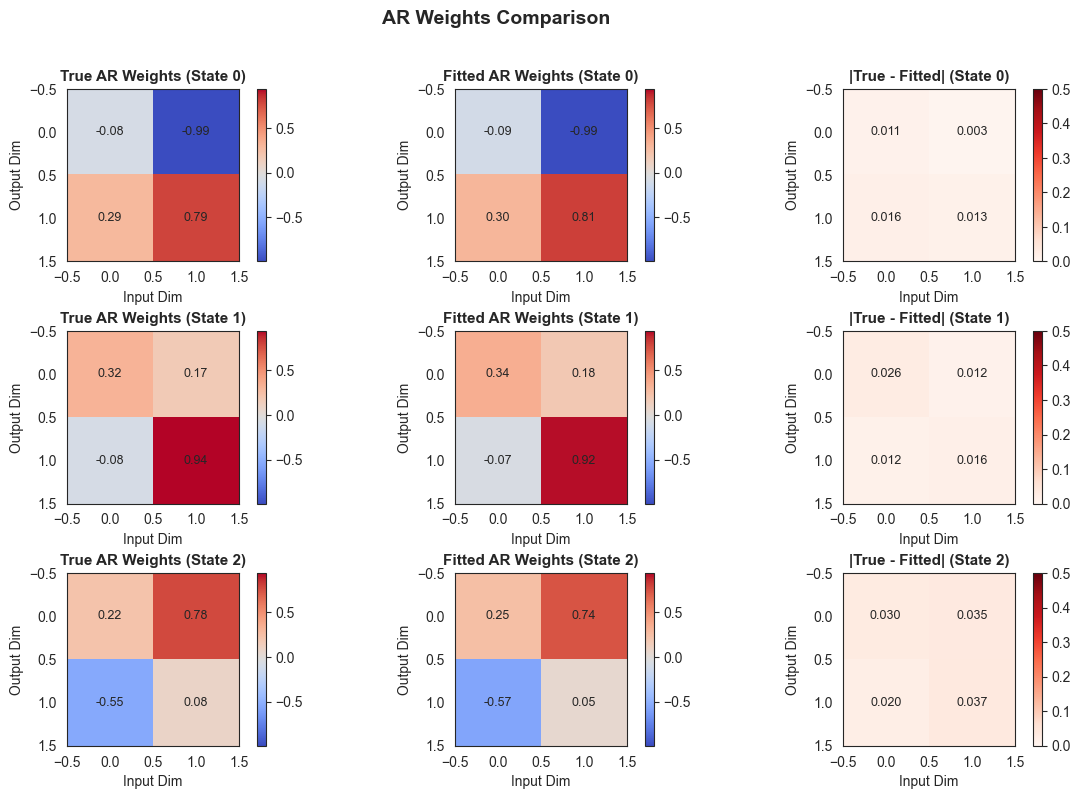

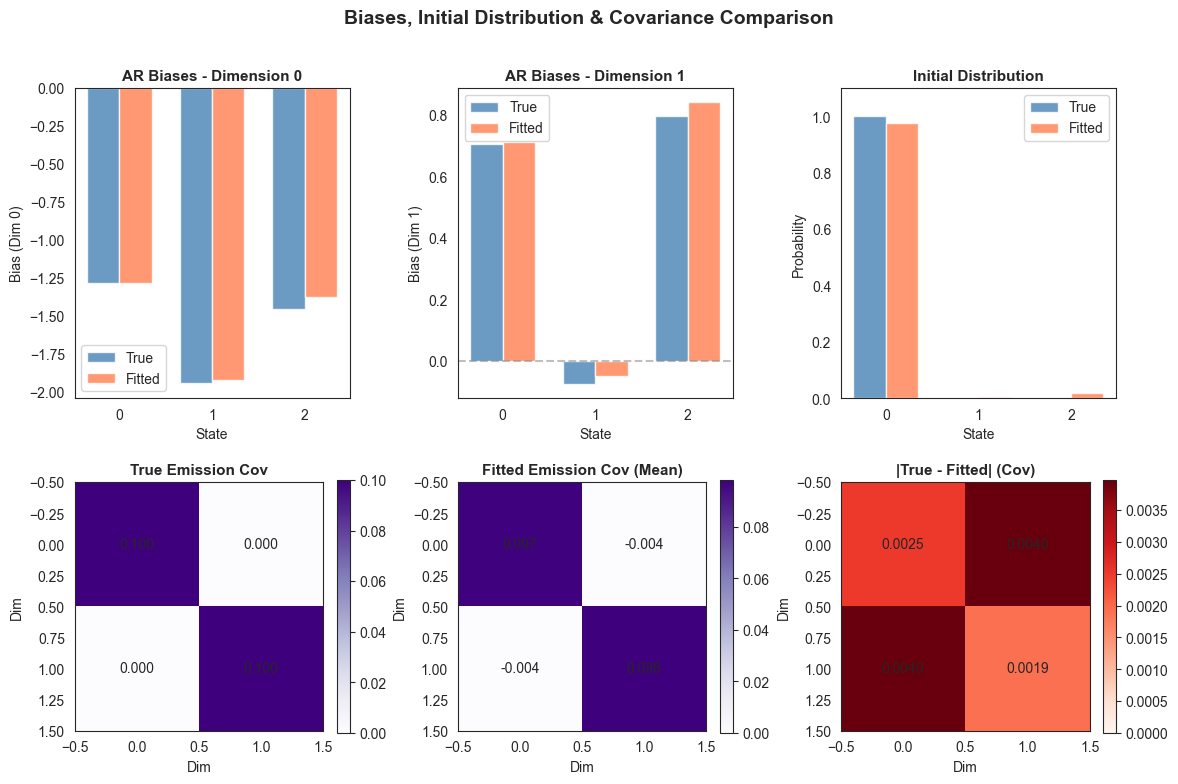


PARAMETER RECOVERY SUMMARY (after alignment)

Transition Matrix (Standard) - Mean Abs Error: 0.0115
Transition Matrix (Division) - Mean Abs Error: 0.0737
AR Weights - Mean Abs Error: 0.0192
AR Biases - Mean Abs Error: 0.0304
Emission Covariance - Mean Abs Error: 0.0031
Initial Distribution - Mean Abs Error: 0.0145


In [22]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import linear_sum_assignment

# Extract true and fitted parameters (raw)
true_P_std = np.array(data['transition_matrices'][0])
true_P_div = np.array(data['transition_matrices'][1])
true_weights = np.array(data['params']['AR_weights'])
true_biases = np.array(data['params']['AR_biases'])
true_cov = np.array(data['params']['cov'])
true_init = np.array(data['initial_distribution'])

fitted_P_std_raw = np.array(fitted_params.transitions.transition_matrix)
fitted_P_div_raw = np.array(fitted_params.division_transitions.transition_matrix)
fitted_weights_raw = np.array(fitted_params.emissions.weights)
fitted_biases_raw = np.array(fitted_params.emissions.biases)
fitted_cov_raw = np.array(fitted_params.emissions.covs)
fitted_init_raw = np.array(fitted_params.initial.probs)

# ============================================================================
# Find optimal state alignment using AR biases (Hungarian algorithm)
# ============================================================================
# Build cost matrix: cost[i,j] = distance between true state i and fitted state j
cost_matrix = np.zeros((num_states, num_states))
for i in range(num_states):
    for j in range(num_states):
        # Use Euclidean distance on biases
        cost_matrix[i, j] = np.linalg.norm(true_biases[i] - fitted_biases_raw[j])

# Solve assignment problem
row_ind, col_ind = linear_sum_assignment(cost_matrix)
# col_ind[i] = which fitted state corresponds to true state i
# We need the inverse: perm[j] = which true state fitted state j corresponds to
# So fitted state col_ind[i] should be relabeled as true state i

# Create permutation: perm[new_label] = old_label
# We want to reorder fitted params so fitted_aligned[i] corresponds to true[i]
perm = col_ind  # perm[true_state] = fitted_state that matches it

print("=" * 60)
print("STATE ALIGNMENT (using AR biases)")
print("=" * 60)
print(f"Cost matrix (Euclidean distance on biases):\n{cost_matrix}")
print(f"\nOptimal assignment: True state i -> Fitted state perm[i]")
print(f"Permutation: {perm}")
print(f"Total alignment cost: {cost_matrix[row_ind, col_ind].sum():.4f}")
print("=" * 60)

# Apply permutation to all fitted parameters
# For state-indexed params: reorder along state axis
fitted_biases = fitted_biases_raw[perm]
fitted_weights = fitted_weights_raw[perm]
fitted_cov = fitted_cov_raw[perm]
fitted_init = fitted_init_raw[perm]

# For transition matrices: permute both rows AND columns
# P_aligned[i,j] = P_raw[perm[i], perm[j]]
fitted_P_std = fitted_P_std_raw[perm][:, perm]
fitted_P_div = fitted_P_div_raw[perm][:, perm]

# ============================================================================
# Figure 1: Transition Matrices
# ============================================================================
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Standard Transition Matrix - True
im1 = axes[0, 0].imshow(true_P_std, cmap='Blues', vmin=0, vmax=1)
axes[0, 0].set_title('True Standard Transition', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('To State')
axes[0, 0].set_ylabel('From State')
for i in range(num_states):
    for j in range(num_states):
        axes[0, 0].text(j, i, f'{true_P_std[i, j]:.2f}', ha='center', va='center', fontsize=10)
plt.colorbar(im1, ax=axes[0, 0], fraction=0.046)

# Standard Transition Matrix - Fitted
im2 = axes[0, 1].imshow(fitted_P_std, cmap='Blues', vmin=0, vmax=1)
axes[0, 1].set_title('Fitted Standard Transition', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('To State')
axes[0, 1].set_ylabel('From State')
for i in range(num_states):
    for j in range(num_states):
        axes[0, 1].text(j, i, f'{fitted_P_std[i, j]:.2f}', ha='center', va='center', fontsize=10)
plt.colorbar(im2, ax=axes[0, 1], fraction=0.046)

# Standard Transition Matrix - Difference
diff_std = np.abs(true_P_std - fitted_P_std)
im3 = axes[0, 2].imshow(diff_std, cmap='Reds', vmin=0, vmax=0.3)
axes[0, 2].set_title('|True - Fitted| (Std)', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('To State')
axes[0, 2].set_ylabel('From State')
for i in range(num_states):
    for j in range(num_states):
        axes[0, 2].text(j, i, f'{diff_std[i, j]:.3f}', ha='center', va='center', fontsize=10)
plt.colorbar(im3, ax=axes[0, 2], fraction=0.046)

# Division Transition Matrix - True
im4 = axes[1, 0].imshow(true_P_div, cmap='Oranges', vmin=0, vmax=1)
axes[1, 0].set_title('True Division Transition', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('To State')
axes[1, 0].set_ylabel('From State')
for i in range(num_states):
    for j in range(num_states):
        axes[1, 0].text(j, i, f'{true_P_div[i, j]:.2f}', ha='center', va='center', fontsize=10)
plt.colorbar(im4, ax=axes[1, 0], fraction=0.046)

# Division Transition Matrix - Fitted
im5 = axes[1, 1].imshow(fitted_P_div, cmap='Oranges', vmin=0, vmax=1)
axes[1, 1].set_title('Fitted Division Transition', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('To State')
axes[1, 1].set_ylabel('From State')
for i in range(num_states):
    for j in range(num_states):
        axes[1, 1].text(j, i, f'{fitted_P_div[i, j]:.2f}', ha='center', va='center', fontsize=10)
plt.colorbar(im5, ax=axes[1, 1], fraction=0.046)

# Division Transition Matrix - Difference
diff_div = np.abs(true_P_div - fitted_P_div)
im6 = axes[1, 2].imshow(diff_div, cmap='Reds', vmin=0, vmax=0.3)
axes[1, 2].set_title('|True - Fitted| (Div)', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('To State')
axes[1, 2].set_ylabel('From State')
for i in range(num_states):
    for j in range(num_states):
        axes[1, 2].text(j, i, f'{diff_div[i, j]:.3f}', ha='center', va='center', fontsize=10)
plt.colorbar(im6, ax=axes[1, 2], fraction=0.046)

plt.suptitle('Transition Matrix Comparison', fontsize=14, fontweight='bold', y=1.0)
plt.tight_layout(pad=1.5, w_pad=0.5, h_pad=0.5)
plt.show()

# ============================================================================
# Figure 2: AR Weights (per state)
# ============================================================================
fig, axes = plt.subplots(num_states, 3, figsize=(12, 8))

vmin_w = min(true_weights.min(), fitted_weights.min())
vmax_w = max(true_weights.max(), fitted_weights.max())

for k in range(num_states):
    # True Weights
    im1 = axes[k, 0].imshow(true_weights[k], cmap='coolwarm', vmin=vmin_w, vmax=vmax_w)
    axes[k, 0].set_title(f'True AR Weights (State {k})', fontsize=11, fontweight='bold')
    axes[k, 0].set_xlabel('Input Dim')
    axes[k, 0].set_ylabel('Output Dim')
    for i in range(emission_dim):
        for j in range(emission_dim):
            axes[k, 0].text(j, i, f'{true_weights[k, i, j]:.2f}', ha='center', va='center', fontsize=9)
    plt.colorbar(im1, ax=axes[k, 0], fraction=0.046)
    
    # Fitted Weights
    im2 = axes[k, 1].imshow(fitted_weights[k], cmap='coolwarm', vmin=vmin_w, vmax=vmax_w)
    axes[k, 1].set_title(f'Fitted AR Weights (State {k})', fontsize=11, fontweight='bold')
    axes[k, 1].set_xlabel('Input Dim')
    axes[k, 1].set_ylabel('Output Dim')
    for i in range(emission_dim):
        for j in range(emission_dim):
            axes[k, 1].text(j, i, f'{fitted_weights[k, i, j]:.2f}', ha='center', va='center', fontsize=9)
    plt.colorbar(im2, ax=axes[k, 1], fraction=0.046)
    
    # Difference
    diff_w = np.abs(true_weights[k] - fitted_weights[k])
    im3 = axes[k, 2].imshow(diff_w, cmap='Reds', vmin=0, vmax=0.5)
    axes[k, 2].set_title(f'|True - Fitted| (State {k})', fontsize=11, fontweight='bold')
    axes[k, 2].set_xlabel('Input Dim')
    axes[k, 2].set_ylabel('Output Dim')
    for i in range(emission_dim):
        for j in range(emission_dim):
            axes[k, 2].text(j, i, f'{diff_w[i, j]:.3f}', ha='center', va='center', fontsize=9)
    plt.colorbar(im3, ax=axes[k, 2], fraction=0.046)

plt.suptitle('AR Weights Comparison', fontsize=14, fontweight='bold', y=1.0)
plt.tight_layout(pad=1.5, w_pad=0.5, h_pad=0.5)
plt.show()

# ============================================================================
# Figure 3: Biases, Initial Distribution, and Covariances
# ============================================================================
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Biases Comparison (Bar Chart)
x = np.arange(num_states)
width = 0.35
for d in range(emission_dim):
    axes[0, d].bar(x - width/2, true_biases[:, d], width, label='True', color='steelblue', alpha=0.8)
    axes[0, d].bar(x + width/2, fitted_biases[:, d], width, label='Fitted', color='coral', alpha=0.8)
    axes[0, d].set_xlabel('State')
    axes[0, d].set_ylabel(f'Bias (Dim {d})')
    axes[0, d].set_title(f'AR Biases - Dimension {d}', fontsize=11, fontweight='bold')
    axes[0, d].set_xticks(x)
    axes[0, d].legend()
    axes[0, d].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# Initial Distribution Comparison
axes[0, 2].bar(x - width/2, true_init, width, label='True', color='steelblue', alpha=0.8)
axes[0, 2].bar(x + width/2, fitted_init, width, label='Fitted', color='coral', alpha=0.8)
axes[0, 2].set_xlabel('State')
axes[0, 2].set_ylabel('Probability')
axes[0, 2].set_title('Initial Distribution', fontsize=11, fontweight='bold')
axes[0, 2].set_xticks(x)
axes[0, 2].legend()
axes[0, 2].set_ylim([0, 1.1])

# Covariance matrices (only showing first state as they should all be the same for true)
# True covariance (same for all states in data generation)
im_cov1 = axes[1, 0].imshow(true_cov, cmap='Purples', vmin=0)
axes[1, 0].set_title('True Emission Cov', fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('Dim')
axes[1, 0].set_ylabel('Dim')
for i in range(emission_dim):
    for j in range(emission_dim):
        axes[1, 0].text(j, i, f'{true_cov[i, j]:.3f}', ha='center', va='center', fontsize=10)
plt.colorbar(im_cov1, ax=axes[1, 0], fraction=0.046)

# Fitted covariances (average across states or show state 0)
fitted_cov_mean = np.mean(fitted_cov, axis=0)
im_cov2 = axes[1, 1].imshow(fitted_cov_mean, cmap='Purples', vmin=0)
axes[1, 1].set_title('Fitted Emission Cov (Mean)', fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('Dim')
axes[1, 1].set_ylabel('Dim')
for i in range(emission_dim):
    for j in range(emission_dim):
        axes[1, 1].text(j, i, f'{fitted_cov_mean[i, j]:.3f}', ha='center', va='center', fontsize=10)
plt.colorbar(im_cov2, ax=axes[1, 1], fraction=0.046)

# Covariance Difference
diff_cov = np.abs(true_cov - fitted_cov_mean)
im_cov3 = axes[1, 2].imshow(diff_cov, cmap='Reds', vmin=0)
axes[1, 2].set_title('|True - Fitted| (Cov)', fontsize=11, fontweight='bold')
axes[1, 2].set_xlabel('Dim')
axes[1, 2].set_ylabel('Dim')
for i in range(emission_dim):
    for j in range(emission_dim):
        axes[1, 2].text(j, i, f'{diff_cov[i, j]:.4f}', ha='center', va='center', fontsize=10)
plt.colorbar(im_cov3, ax=axes[1, 2], fraction=0.046)

plt.suptitle('Biases, Initial Distribution & Covariance Comparison', fontsize=14, fontweight='bold', y=1.0)
plt.tight_layout(pad=1.5, w_pad=0.5, h_pad=0.5)
plt.show()

# ============================================================================
# Summary Statistics
# ============================================================================
print("\n" + "=" * 60)
print("PARAMETER RECOVERY SUMMARY (after alignment)")
print("=" * 60)
print(f"\nTransition Matrix (Standard) - Mean Abs Error: {np.mean(diff_std):.4f}")
print(f"Transition Matrix (Division) - Mean Abs Error: {np.mean(diff_div):.4f}")
print(f"AR Weights - Mean Abs Error: {np.mean(np.abs(true_weights - fitted_weights)):.4f}")
print(f"AR Biases - Mean Abs Error: {np.mean(np.abs(true_biases - fitted_biases)):.4f}")
print(f"Emission Covariance - Mean Abs Error: {np.mean(diff_cov):.4f}")
print(f"Initial Distribution - Mean Abs Error: {np.mean(np.abs(true_init - fitted_init)):.4f}")
